In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PIL
from keras.applications import VGG16,imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.models import Model
import numpy as np
import glob
import os
from IPython.display import Image,display

import pickle

Using TensorFlow backend.


In [2]:
from PIL import ImageDraw
def draw_bbox(bbox):
    img = PIL.Image.open('Data/DeepFashion/'+bbox['image_name']).convert('RGBA')
    
    lx = bbox['x_1']
    ly = bbox['y_1']
    ux = bbox['x_2']
    uy = bbox['y_2']
    rect = PIL.Image.new('RGBA', img.size, (255,255,255,0))
    d = ImageDraw.Draw(img)
    d.rectangle(((lx,ly), (ux,uy)), outline="red")
    return PIL.Image.alpha_composite(img,rect)

def gen_pairs(N,image_df,feature_matrix,metric='L2'):
    img_index = np.random.randint(image_df.shape[0],size=N)
    if metric == 'H':
        bin_mat = (feature_matrix > 0)
    for i in img_index:
        img_feature = feature_matrix[i,:]
        if metric == 'L2':
            dist = np.sum((feature_matrix-img_feature)**2,axis=1)
        elif metric == 'L1':
            dist = np.sum(np.abs(feature_matrix-img_feature),axis=1)
        elif metric == 'H':
            img_feature = (img_feature>0)
            dist = np.sum(np.logical_xor(img_feature,bin_mat),axis=1)
        
        j=1
        match = np.argsort(dist)[j]
        while dist[match]<=0:
            j += 1
            match = np.argsort(dist)[j]

        print(f'distance: {np.sqrt(dist[match])}')
        display(draw_bbox(image_df.iloc[i]))
        display(draw_bbox(image_df.iloc[match]))

In [3]:
tops = pickle.load(open('Data/feature_matrix/tops_10000_df.p','rb'))
fc6_tops = pickle.load(open('./Data/feature_matrix/FC6_relu_tops.p','rb'))
fc8_tops = pickle.load(open('./Data/feature_matrix/FC8_linear_tops.p','rb'))
fc8_relu_tops = np.where(fc8_tops>0,fc8_tops,0)

distance: 24.515301344262525


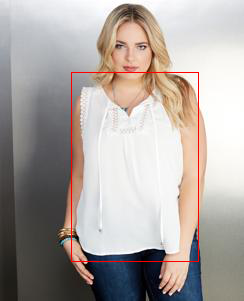

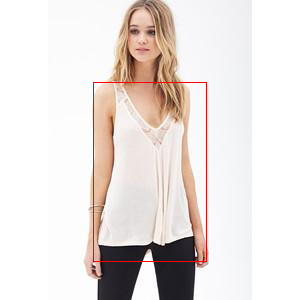

distance: 29.732137494637012


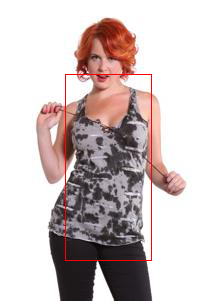

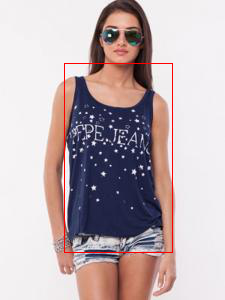

distance: 24.145392935299274


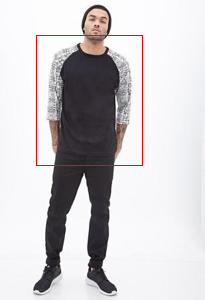

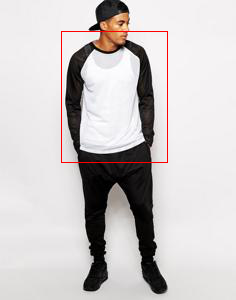

distance: 27.09243436828813


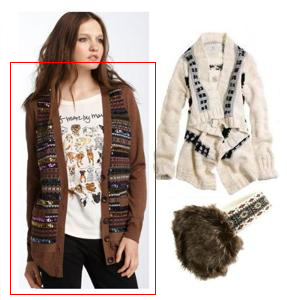

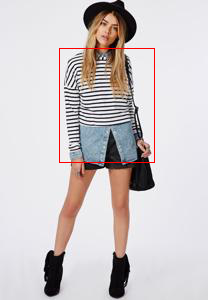

In [62]:
gen_pairs(4,tops,fc6_tops,'H')

distance: 17.89786720275879


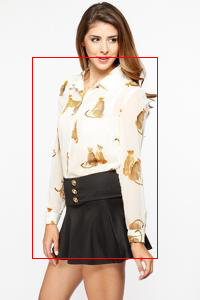

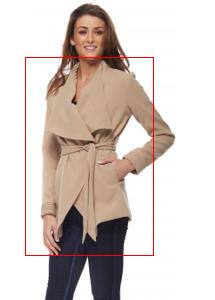

distance: 19.512073516845703


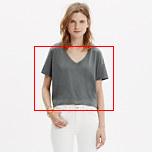

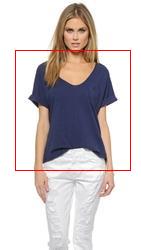

distance: 20.972715377807617


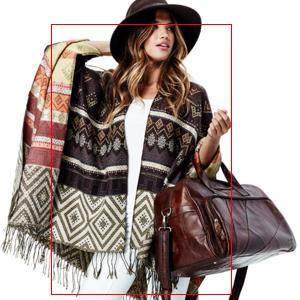

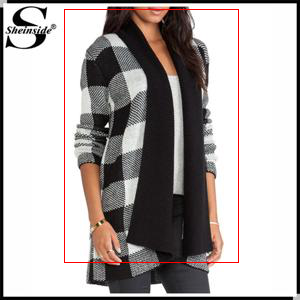

distance: 21.18683624267578


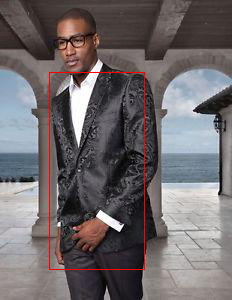

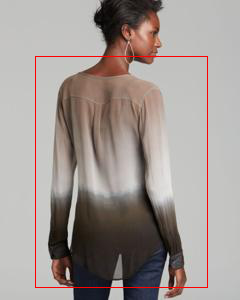

In [55]:
gen_pairs(4,tops,fc8_relu_tops,'L1')

In [10]:
bottoms = pickle.load(open('Data/feature_matrix/bottoms_10000_df.p','rb'))
fc6_bottoms = pickle.load(open('./Data/feature_matrix/FC6_relu_bottoms.p','rb'))
fc8_bottoms = pickle.load(open('./Data/feature_matrix/FC8_linear_bottoms.p','rb'))
fc8_relu_bottoms = np.where(fc8_bottoms>0,fc8_bottoms,0)

distance: 18.373014450073242


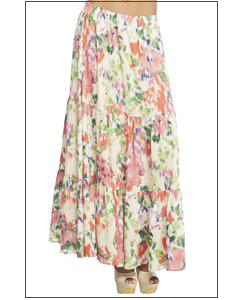

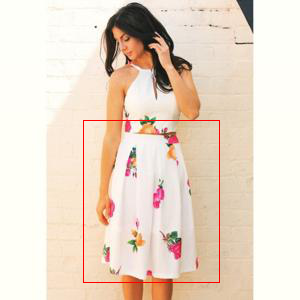

distance: 18.186208724975586


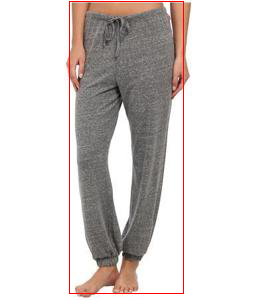

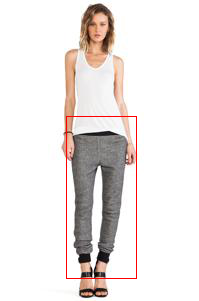

distance: 17.622133255004883


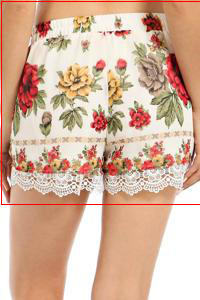

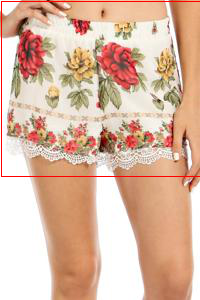

distance: 16.83423614501953


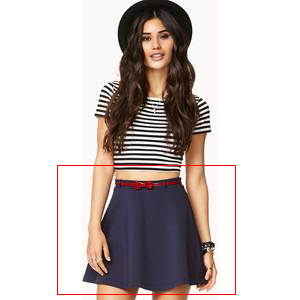

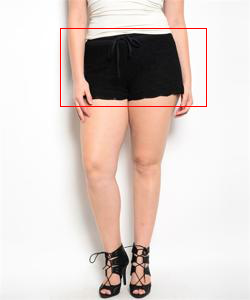

In [53]:
gen_pairs(4,bottoms,fc8_relu_bottoms,'L1')

In [11]:
cat = pd.read_table('Data/DeepFashion/list_category_img.txt',sep='\s+')

In [12]:
tops['category_label'] = cat.iloc[tops.index]['category_label']
bottoms['category_label'] = cat.iloc[bottoms.index]['category_label']

In [24]:
tb = pd.concat((tops,bottoms),axis=0)
fc8_relu_tb = np.concatenate((fc8_relu_tops,fc8_relu_bottoms),axis=0)
fc8_linear_tb = np.concatenate((fc8_tops,fc8_bottoms),axis=0)
fc6_relu_tb = np.concatenate((fc6_tops,fc6_bottoms),axis=0)

In [4]:
def test_pairs(N,image_df,feature_matrix,metric='L2'):
    img_index = np.random.randint(image_df.shape[0],size=N)
    cat_match = []
    if metric == 'H':
        bin_mat = (feature_matrix > 0)
    for i in img_index:
        img_feature = feature_matrix[i,:]
        if metric == 'L2':
            dist = np.sum((feature_matrix-img_feature)**2,axis=1)
        elif metric == 'L1':
            dist = np.sum(np.abs(feature_matrix-img_feature),axis=1)
        elif metric == 'H':
            img_feature = (img_feature>0)
            dist = np.sum(np.logical_xor(img_feature,bin_mat),axis=1)
        
        j=1
        match = np.argsort(dist)[j]
        while dist[match]<=0:
            j += 1
            match = np.argsort(dist)[j]

        cat_match.append(image_df.iloc[i]['category_label'] == image_df.iloc[match]['category_label'])
        
    return cat_match

In [5]:
def random_pairs(N,image_df):
    img_index = np.random.randint(image_df.shape[0],size=N)
    match_index = np.random.randint(image_df.shape[0],size=N)
    return (image_df.iloc[img_index]['category_label'].values
            == image_df.iloc[match_index]['category_label'].values)
   

In [105]:
r_score = random_pairs(1000,tb)
print(f'P@1: {np.mean(r_score)}')

P@1: 0.082


In [106]:
import time
start = time.time()
fc6_relu_L2_score = test_pairs(1000,tb,fc6_relu_tb,'L2')
print(f'{time.time()-start:.2f} s')
print(f'P@1: {np.mean(fc6_relu_L2_score)}')

280.27 s
P@1: 0.459


In [107]:
start = time.time()
fc6_relu_H_score = test_pairs(1000,tb,fc6_relu_tb,'H')
print(f'{time.time()-start:.2f} s')
print(f'P@1: {np.mean(fc6_relu_H_score)}')

174.62 s
P@1: 0.501


In [108]:
start = time.time()
fc6_relu_L1_score = test_pairs(1000,tb,fc6_relu_tb,'L1')
print(f'{time.time()-start:.2f} s')
print(f'P@1: {np.mean(fc6_relu_L1_score)}')

468.66 s
P@1: 0.442


In [99]:
start = time.time()
fc8_relu_L1_score = test_pairs(1000,tb,fc8_relu_tb,'L1')
print(f'{time.time()-start:.2f} s')
print(f'P@1: {np.mean(fc8_relu_L1_score)}')

76.34 s
P@1: 0.45


In [100]:
start = time.time()
fc8_relu_L2_score = test_pairs(1000,tb,fc8_relu_tb,'L2')
print(f'{time.time()-start:.2f} s')
print(f'P@1: {np.mean(fc8_relu_L2_score)}')

48.17 s
P@1: 0.411


In [101]:
start = time.time()
fc8_relu_H_score = test_pairs(1000,tb,fc8_relu_tb,'H')
print(f'{time.time()-start:.2f} s')
print(f'P@1: {np.mean(fc8_relu_H_score)}')

41.73 s
P@1: 0.447


In [109]:
print(f'FC6 L1: {np.mean(fc6_relu_L1_score)}')
print(f'FC6 L2: {np.mean(fc6_relu_L2_score)}')
print(f'FC6 H: {np.mean(fc6_relu_H_score)}')
print(f'FC8 L1: {np.mean(fc8_relu_L1_score)}')
print(f'FC8 L2: {np.mean(fc8_relu_L2_score)}')
print(f'FC8 H: {np.mean(fc8_relu_H_score)}')

FC6 L1: 0.442
FC6 L2: 0.459
FC6 H: 0.501
FC8 L1: 0.45
FC8 L2: 0.411
FC8 H: 0.447


In [15]:
fc6_retrain_tops = pickle.load(open('./Data/feature_matrix/fc6_retrain_tops.p','rb'))

In [13]:
r_score = random_pairs(1000,tops)
print(f'P@1: {np.mean(r_score)}')

P@1: 0.151


In [19]:
import time
start = time.time()
fc6_retrain_H_score = test_pairs(1000,tops,fc6_retrain_tops,'H')
print(f'{time.time()-start:.2f} s')
print(f'P@1: {np.mean(fc6_retrain_H_score)}')

IndexError: index 10000 is out of bounds for axis 0 with size 10000

In [25]:
fc6_relu_tb

array([[ 0.        ,  1.59934402,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  4.2725091 ],
       [ 0.        ,  0.        ,  6.4825058 , ...,  0.        ,
         9.35505962,  2.42070603],
       ..., 
       [ 0.        ,  7.30356216,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  2.80765295,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         5.23704672,  9.1833849 ]], dtype=float32)